In [1]:
import os
import json
import pyqg_subgrid_experiments as pse
from pyqg_subgrid_experiments.models import ProbabilisticCNN
import argparse
%load_ext autoreload
%autoreload 2

In [2]:
import torch
torch.cuda.is_available()

True

In [24]:
parser = argparse.ArgumentParser()
parser.add_argument('--train_set', type=str, default="/scratch/zanna/data/pyqg/data/train/*.nc")
parser.add_argument('--test_set', type=str, default="/scratch/zanna/data/pyqg/data/test/*.nc")
parser.add_argument('--transfer_set', type=str, default="/scratch/zanna/data/pyqg/data/transfer/*.nc")
parser.add_argument('--save_dir', type=str, default="PCNN")
parser.add_argument('--inputs', type=str, default="u,v,q")
parser.add_argument('--targets', type=str, default="q_forcing_advection")
parser.add_argument('--zero_mean', type=int, default=1)
parser.add_argument('--num_epochs', type=int, default=50)
parser.add_argument('--layerwise_inputs', type=int, default=0)
parser.add_argument('--layerwise_targets', type=int, default=0)
parser.add_argument('--learning_rate', type=float, default=0.0001)
args = parser.parse_args("")

In [4]:
train = pse.Dataset(args.train_set)

In [5]:
test = pse.Dataset(args.test_set)
xfer = pse.Dataset(args.transfer_set)

In [6]:
save_dir = 'PCNN'
test_dir = os.path.join(save_dir, "test")
xfer_dir = os.path.join(save_dir, "transfer")
#os.system(f"rm -r {save_dir}")
for d in [save_dir, test_dir, xfer_dir]:
    os.system(f"mkdir -p {d}") 

In [7]:
with open(f"{save_dir}/model_config.json", 'w') as f:
    f.write(json.dumps(args.__dict__))

In [23]:
param = pse.CNNParameterization.train_on(train, save_dir,
            inputs=args.inputs.split(","),
            targets=args.targets.split(","),
            layerwise_inputs=False,
            layerwise_targets=True,
            zero_mean=args.zero_mean,
            num_epochs=100,
            model_class=ProbabilisticCNN,
            learning_rate=0.001,
            dataset_test = test,
            channel_type = 'var')

Current mode: True
Mode after train(): True


KeyboardInterrupt: 

In [14]:
for i, model in enumerate(param.models):
    print('model number', i)
    model.check_channels()

model number 0
Current mode: True
Mode after eval(): False
min, max mean: -0.7907760143280029 0.7982652187347412
min, max std : 0.17958545684814453 0.7567946314811707
model number 1
Current mode: True
Mode after eval(): False
min, max mean: -0.858313798904419 1.0432753562927246
min, max std : 0.3319544792175293 1.293800950050354


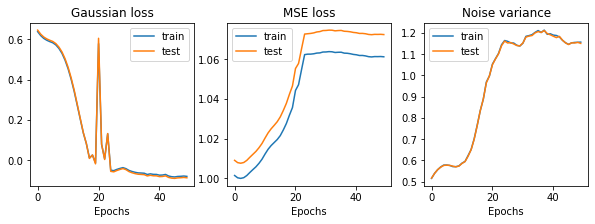

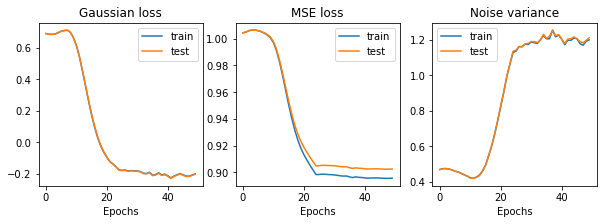

In [15]:
import matplotlib.pyplot as plt
import numpy as np
for i in range(len(param.models)):
    plt.figure(figsize=(10,3))
    plt.subplot(131)
    plt.plot(np.arange(50),param.models[i].loss_history['train_gauss'], np.arange(50),param.models[i].loss_history['test_gauss'])
    plt.legend(['train', 'test'])
    plt.xlabel('Epochs')
    plt.title('Gaussian loss')

    plt.subplot(132)
    plt.plot(np.arange(50),param.models[i].loss_history['train_mse'], np.arange(50),param.models[i].loss_history['test_mse'])
    plt.legend(['train', 'test'])
    plt.xlabel('Epochs')
    plt.title('MSE loss')
    
    plt.subplot(133)
    plt.plot(np.arange(50),param.models[i].loss_history['train_noise'], np.arange(50),param.models[i].loss_history['test_noise'])
    plt.legend(['train', 'test'])
    plt.xlabel('Epochs')
    plt.title('Noise variance')

In [15]:
test_result = param.test_offline(test, os.path.join(test_dir, "offline_metrics.nc"))

In [18]:
transfer_result = param.test_offline(xfer, os.path.join(xfer_dir, "offline_metrics.nc"))

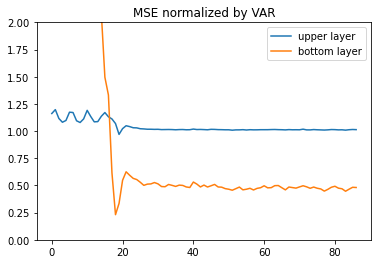

In [29]:
ds = test_result
plt.plot(1-ds.q_forcing_advection_temporal_skill)
plt.ylim([0,2])
plt.legend(['upper layer', 'bottom layer'])
plt.title('MSE normalized by VAR')
#plt.hlines(y=[0.15,0.05],xmin=20,xmax=90,linestyle='--')
#plt.text(5,0.15,'y=0.15')
#plt.text(5,0.05,'y=0.05')
plt.show()

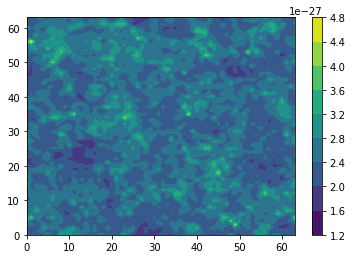

In [41]:
plt.contourf(ds.q_forcing_advection_spatial_mse[1,:,:])
plt.colorbar()

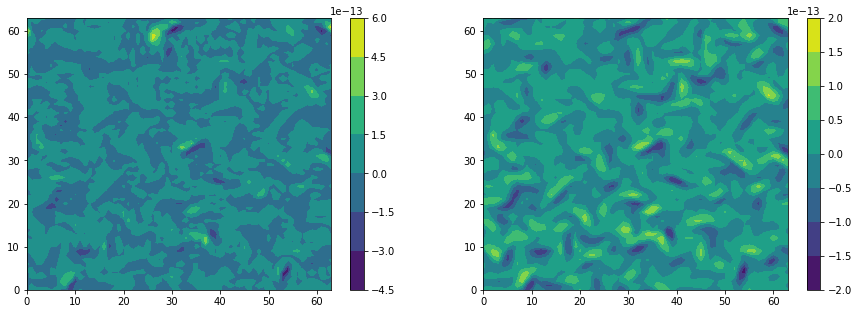

In [42]:
nn = 0
tt = 50
nlev = 1

xx = ds.q_forcing_advection[nn,tt,nlev,:,:]
yy = ds.q_forcing_advection_predictions[nn,tt,nlev,:,:]

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.contourf(xx)
plt.colorbar()

plt.subplot(1,2,2)
plt.contourf(yy)
plt.colorbar()

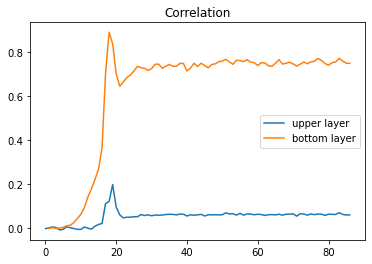

In [44]:
ds = test_result
plt.plot(ds.q_forcing_advection_temporal_correlation)
#plt.ylim([0,2])
plt.legend(['upper layer', 'bottom layer'])
plt.title('Correlation')
plt.show()

In [45]:
ds

<xarray.Dataset>
Dimensions:                                   (time: 87, lev: 2, x: 64, y: 64, run: 25)
Coordinates:
  * time                                      (time) timedelta64[ns] 0 days 0...
  * x                                         (x) float64 7.812e+03 ... 9.922...
  * y                                         (y) float64 7.812e+03 ... 9.922...
  * lev                                       (lev) int32 1 2
Dimensions without coordinates: run
Data variables: (12/14)
    q_forcing_advection_temporal_mse          (time, lev) float32 1.378e-28 ....
    q_forcing_advection_temporal_skill        (time, lev) float32 -0.1616 ......
    q_forcing_advection_temporal_correlation  (time, lev) float64 -0.002245 ....
    q_forcing_advection                       (run, time, lev, y, x) float32 ...
    q_forcing_advection_predictions           (run, time, lev, y, x) float32 ...
    q_forcing_advection_spatial_mse           (lev, y, x) float32 1.329e-23 ....
    ...                                        ...
    q_forcing_advection_mse                   (lev) float32 1.335e-23 2.438e-27
    q_forcing_advection_skill                 (lev) float32 -0.0143 0.5078
    q_forcing_advection_correlation           (lev) float64 0.0608 0.7417
    correlation                               (lev) float64 0.0608 0.7417
    mse                                       (lev) float32 1.335e-23 2.438e-27
    skill                                     (lev) float32 -0.0143 0.5078
Attributes: (12/26)
    pyqg:beta:       1.5e-11
    pyqg:delta:      0.25
    pyqg:del2:       0.8
    pyqg:dt:         3600.0
    pyqg:filterfac:  23.6
    pyqg:L:          1000000.0
    ...              ...
    pyqg:W:          1000000.0
    title:           pyqg: Python Quasigeostrophic Model
    reference:       https://pyqg.readthedocs.io/en/latest/index.html
    hires:           256
    lores:           64
    pyqg_params:     {"nx": 64, "dt": 3600.0, "tmax": 311040000.0, "tavestart...

In [53]:
'std' == 'std'

True

RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [11]:
a = torch.randn(10)
b = torch.randn(10)
c = a * b
print(c.shape)

torch.Size([10])


In [19]:
1%10

1